In [6]:
# Install necessary packages
!pip install mne numpy matplotlib seaborn scikit-learn tensorflow nilearn

# Import statements
import numpy as np
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper, tfr_morlet
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from nilearn.connectome import ConnectivityMeasure


In [7]:
# Upload files manually
from google.colab import files
uploaded = files.upload()

# Load the data
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
raw = mne.io.read_raw_eeglab(file_name, preload=True)

Saving sub-001-eeg-sub-001_task-eyesclosed_eeg.set to sub-001-eeg-sub-001_task-eyesclosed_eeg (1).set


In [8]:
# Preprocessing: Filtering
raw.filter(1., 40., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


Using matplotlib as 2D backend.


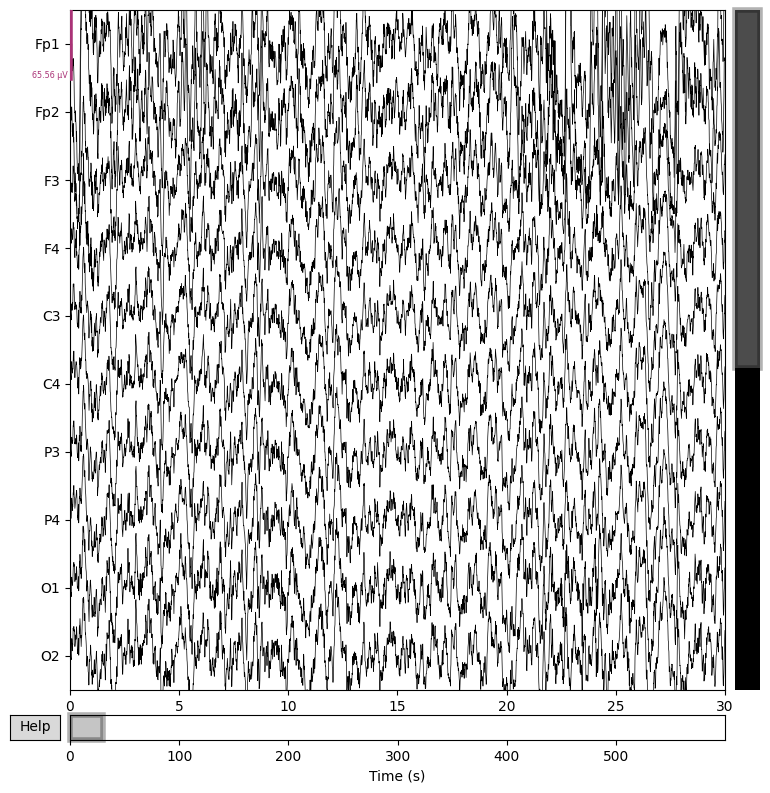

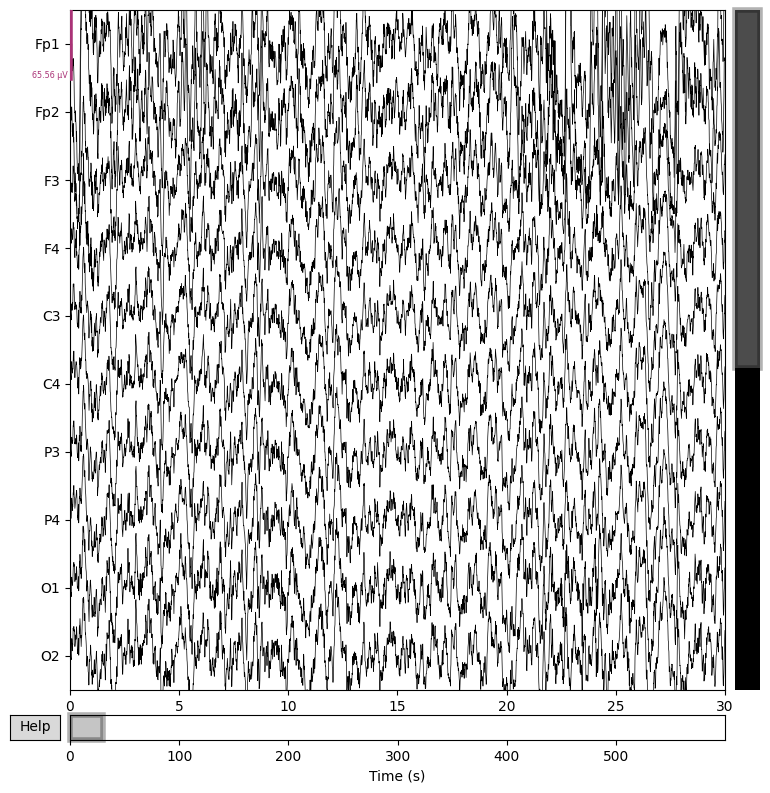

In [9]:
# Plot raw data
raw.plot(n_channels=10, duration=30, scalings='auto')

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 9.7s.


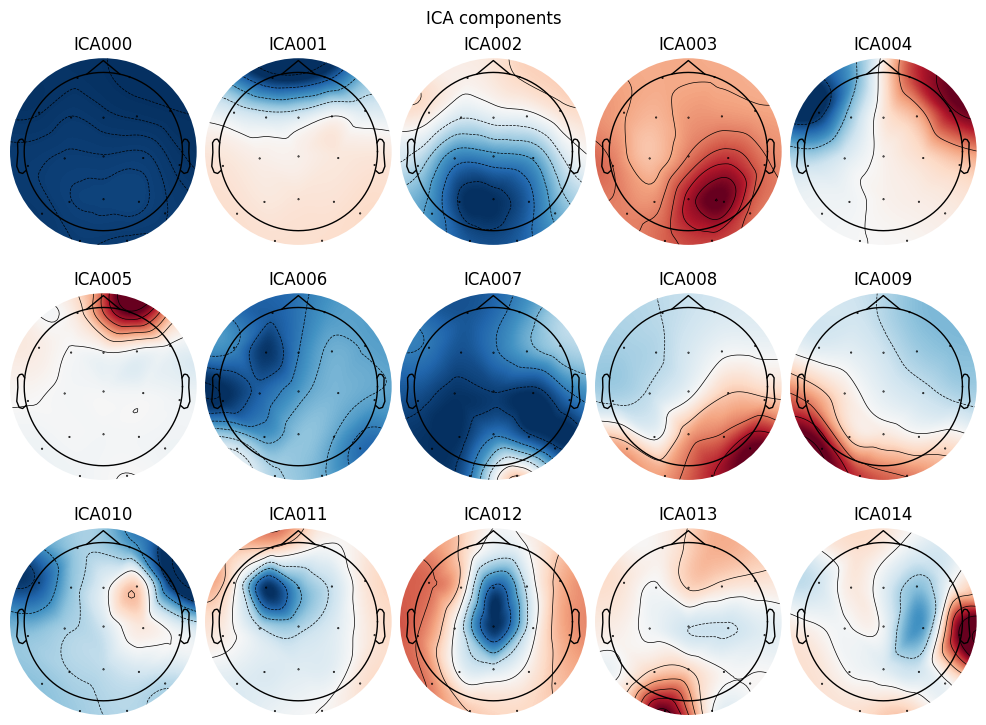

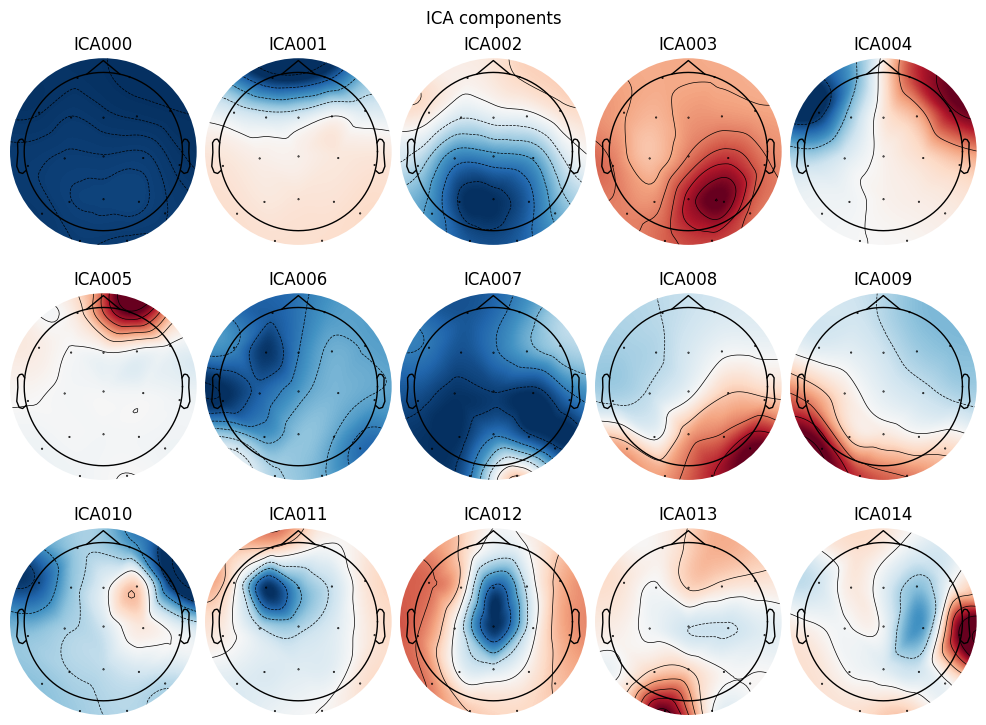

In [10]:
# Set up and fit the ICA
ica = ICA(n_components=15, random_state=97)
ica.fit(raw)
ica.plot_components()

In [11]:
# Find and remove artifacts
ica.exclude = [0, 1]  # indices of the components to exclude
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [12]:
# Inspect annotations
print("Annotations:", raw.annotations)

Annotations: <Annotations | 0 segments>


In [29]:
# Check if there are annotations
if not raw.annotations:
    # Create artificial events if there are no annotations
    sfreq = raw.info['sfreq']
    duration = raw.times[-1]  # Duration in seconds
    n_events = 20  # Number of events to create
    event_times = np.linspace(0, duration, n_events)
    # Alternate between two classes: 1 and 2
    events = np.array([[int(time * sfreq), 0, 1 if i % 2 == 0 else 2] for i, time in enumerate(event_times)], dtype=int)
    event_id = {'Class 1': 1, 'Class 2': 2}
else:
    # Extract events from annotations
    events, event_id = mne.events_from_annotations(raw)

print("Events:", events)
print("Event ID:", event_id)

Events: [[     0      0      1]
 [ 15784      0      2]
 [ 31568      0      1]
 [ 47352      0      2]
 [ 63136      0      1]
 [ 78920      0      2]
 [ 94704      0      1]
 [110489      0      2]
 [126273      0      1]
 [142057      0      2]
 [157841      0      1]
 [173625      0      2]
 [189409      0      1]
 [205194      0      2]
 [220978      0      1]
 [236762      0      2]
 [252546      0      1]
 [268330      0      2]
 [284114      0      1]
 [299899      0      2]]
Event ID: {'Class 1': 1, 'Class 2': 2}


Not setting metadata
20 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 351 original time points ...
2 bad epochs dropped


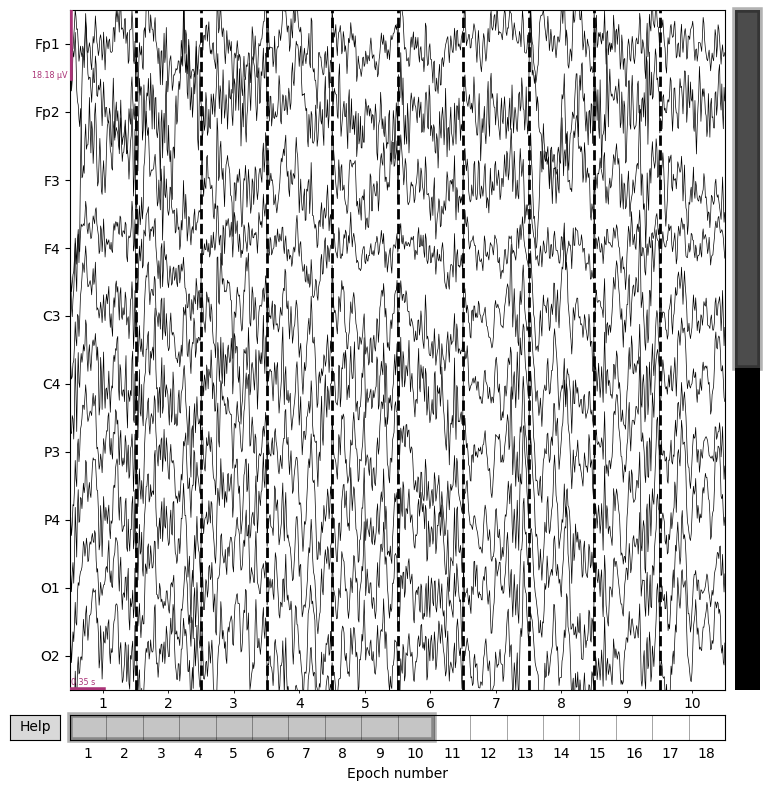

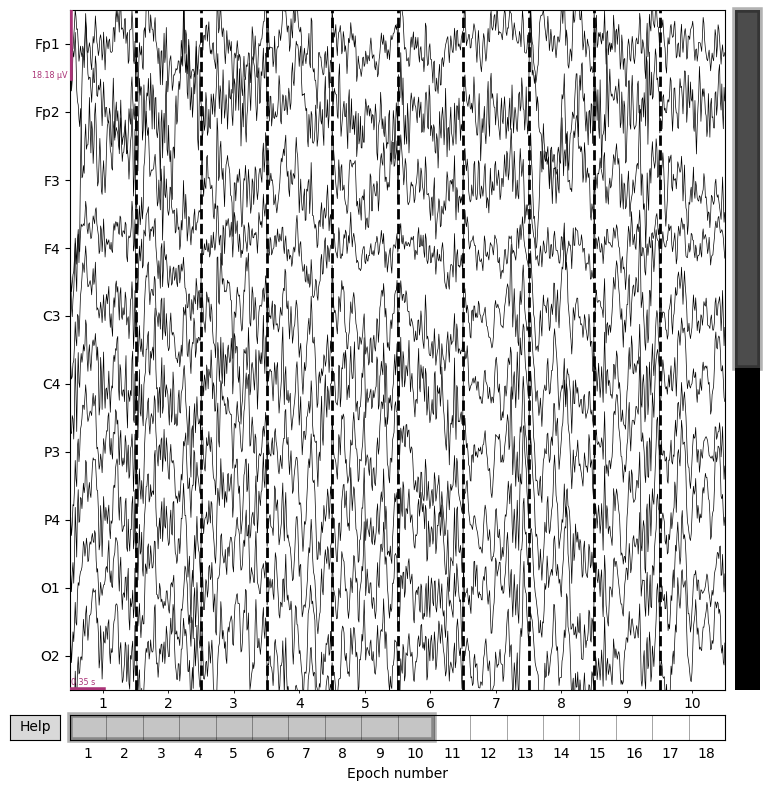

In [30]:
# Check if events are correctly extracted
if events.size == 0:
    raise ValueError("No events found. Please check your annotations and event definitions.")

epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, baseline=(None, 0), preload=True)
# Plot epochs
epochs.plot(n_channels=10, n_epochs=10, scalings='auto')

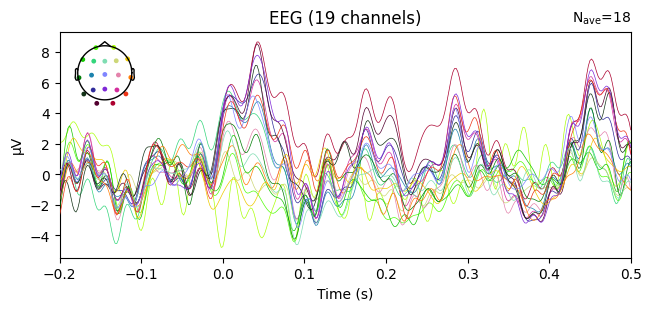

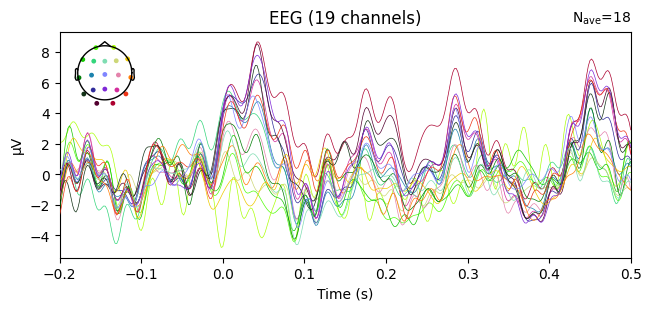

In [31]:
# Compute and plot ERP
erp = epochs.average()
erp.plot()

In [32]:
# Time-frequency analysis with Morlet wavelets
freqs = np.logspace(*np.log10([6, 30]), num=8)
n_cycles = freqs / 4.  # Using shorter wavelets
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, decim=3, n_jobs=1)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


Applying baseline correction (mode: logratio)


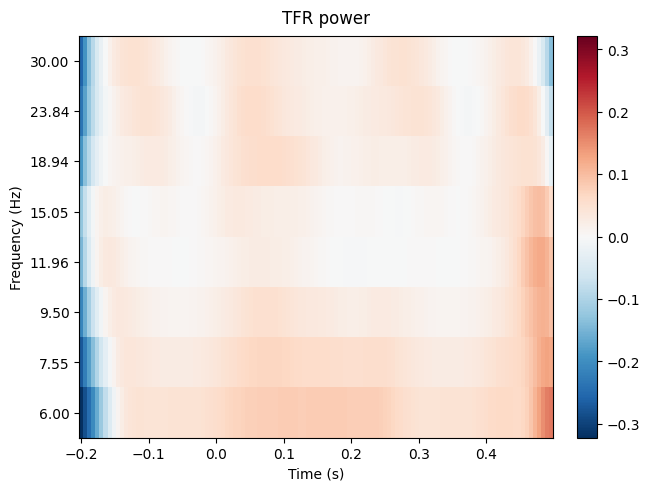

[<Figure size 640x480 with 2 Axes>]

In [ ]:
# Plot time-frequency power
power.plot([0], baseline=(None, 0), mode='logratio', title='TFR power')

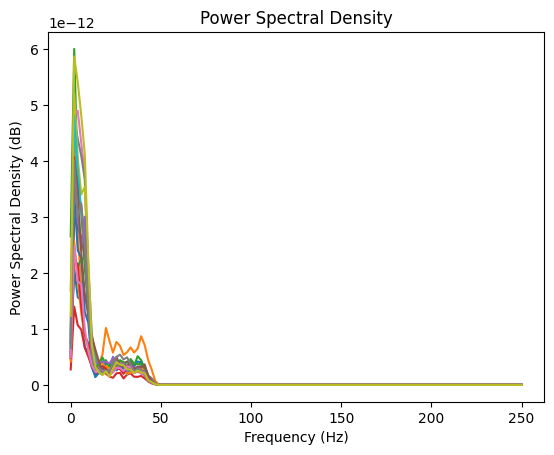

In [33]:
# Spectral analysis: Power spectral density using Welch's method
psds = []
sfreq = raw.info['sfreq']
for epoch in epochs:
    f, pxx = welch(epoch, sfreq, nperseg=256)
    psds.append(pxx)
psds = np.array(psds)
psds_mean = psds.mean(axis=0)

plt.plot(f, psds_mean.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Power Spectral Density')
plt.show()

In [ ]:
# Connectivity analysis using Nilearn
connectivity_measure = ConnectivityMeasure(kind='correlation')
connectivity_matrix = connectivity_measure.fit_transform([epochs.get_data().reshape(len(epochs), -1)])[0]

<ipython-input-32-3918904a8ac0>:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  connectivity_matrix = connectivity_measure.fit_transform([epochs.get_data().reshape(len(epochs), -1)])[0]


In [ ]:
# Plot connectivity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(connectivity_matrix, annot=True, cmap='viridis')
plt.title('Connectivity Matrix (Correlation)')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.show()

<ipython-input-34-21f44d3a8dc5>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data = epochs.get_data()


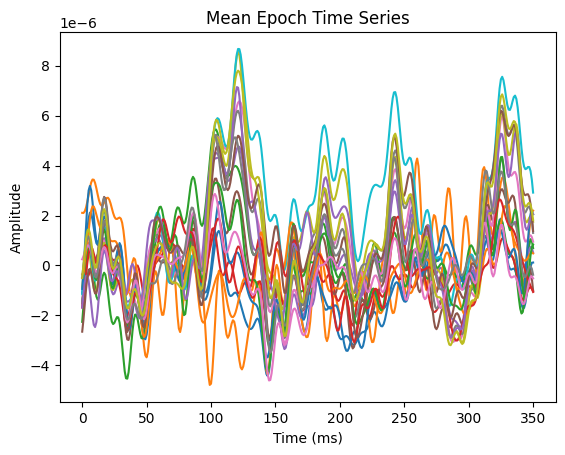

In [34]:
# Time series analysis
epoch_data = epochs.get_data()
mean_epoch = epoch_data.mean(axis=0)
plt.plot(mean_epoch.T)
plt.title('Mean Epoch Time Series')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

In [35]:
# Machine learning: Feature extraction
X = psds.reshape(len(psds), -1)
y = epochs.events[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4

Confusion Matrix:
 [[0 2]
 [0 2]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Deep learning: Simple CNN
X_cnn = epoch_data.transpose((0, 2, 1))  # Reshape for Conv1D: (samples, time, channels)
y_cnn = epochs.events[:, -1] - 1  # Adjust labels to be in the range [0, 1]

In [44]:
# Ensure y_cnn contains labels in the range [0, num_classes-1]
unique_classes = np.unique(y_cnn)
num_classes = len(unique_classes)
print(f"Unique classes in y_cnn: {unique_classes}")

Unique classes in y_cnn: [0 1]


In [45]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)

In [46]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test_cnn))

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 0.6924 - accuracy: 0.7857 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 51ms/step - loss: 0.6913 - accuracy: 0.5714 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 0.6973 - accuracy: 0.2857 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 53ms/step - loss: 0.6895 - accuracy: 0.6429 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 51ms/step - loss: 0.6915 - accuracy: 0.6429 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=============

In [49]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_cnn, y_test_cnn)
print(f"Test accuracy: {accuracy:.4f}")

1/1 [==============================] - 0s 40ms/step - loss: 0.6932 - accuracy: 0.5000
Test accuracy: 0.5000
